# Analysis of hover points

In [80]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from firefly_preprocessing import get_dfs
import scipy
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq
from scipy import signal

from tools import data_loader
from tools.helper_functions import split_sequences, normalize, get_y_bound

In [81]:
# capture output of get_dfs function

In [82]:
%%capture     


data_directory = ['../flight_data/2021-12-10_hangar', '../flight_data/2022-01-24_hangar',
                  '../flight_data/2022-01-24_hangar']

ulg_number = [109, 143, 145]
firefly_number = [54, 5, 9]

log_number = 1
firefly_df, arm_df, ulg_df = get_dfs(data_directory[log_number],
                                         ulg_number[log_number], firefly_number[log_number])

In [83]:
data_directory[log_number]

'../flight_data/2022-01-24_hangar'

In [84]:
# get motor data and calculate power

current = data_loader.get_current(firefly_df)
voltage = data_loader.get_voltage(firefly_df)
rpm = data_loader.get_rpm(firefly_df)
p_motor, p_motorpair, p_upper, p_lower  = data_loader.get_power(firefly_df)
in_throttle = data_loader.get_in_throttle(firefly_df)
out_throttle = data_loader.get_out_throttle(firefly_df)
nsh_cmd = firefly_df['optim_nsh_cmd'].values

time = firefly_df.index.values

In [85]:
# calculate total power of all motors
p_total = sum(p_motor.values())
p_upper_total = sum(p_upper.values())
p_lower_total = sum(p_lower.values())

# apply moving average filter smooth power signals
window = 5

in_throttle_av = data_loader.moving_average(in_throttle, window)
p_motor_av = data_loader.moving_average(p_motor, window)
p_motorpair_av = data_loader.moving_average(p_motorpair, window) 
p_total_av = data_loader.moving_average(p_total, window)
p_upper_av = data_loader.moving_average(p_upper, window)
p_lower_av = data_loader.moving_average(p_lower, window)
p_upper_total_av = data_loader.moving_average(p_upper_total, window)
p_lower_total_av = data_loader.moving_average(p_lower_total, window)

In [86]:
# get positions, velocities and angular rates

x = ulg_df['ulg_pv_df']['x'].values
y = ulg_df['ulg_pv_df']['y'].values
z = ulg_df['ulg_pv_df']['z'].values

u = ulg_df['ulg_pv_df']['vx'].values
v = ulg_df['ulg_pv_df']['vy'].values
w = ulg_df['ulg_pv_df']['vz'].values

p = ulg_df['ulg_angvel_df']['roll rate'].values
q = ulg_df['ulg_angvel_df']['pitch rate'].values
r = ulg_df['ulg_angvel_df']['yaw rate'].values

In [87]:
# global plotting settings
markersize = 3
cmap = cm.cool

# set t0 and t1 to plot only part of time domain
t0 = 0
t1 = time.size

In [88]:
# calculate velocity throug derivation of position

dt = time[1] - time[0]
dy = np.gradient(y, dt)
dx = np.gradient(x, dt)
dz = np.gradient(z, dt)

<IPython.core.display.Javascript object>


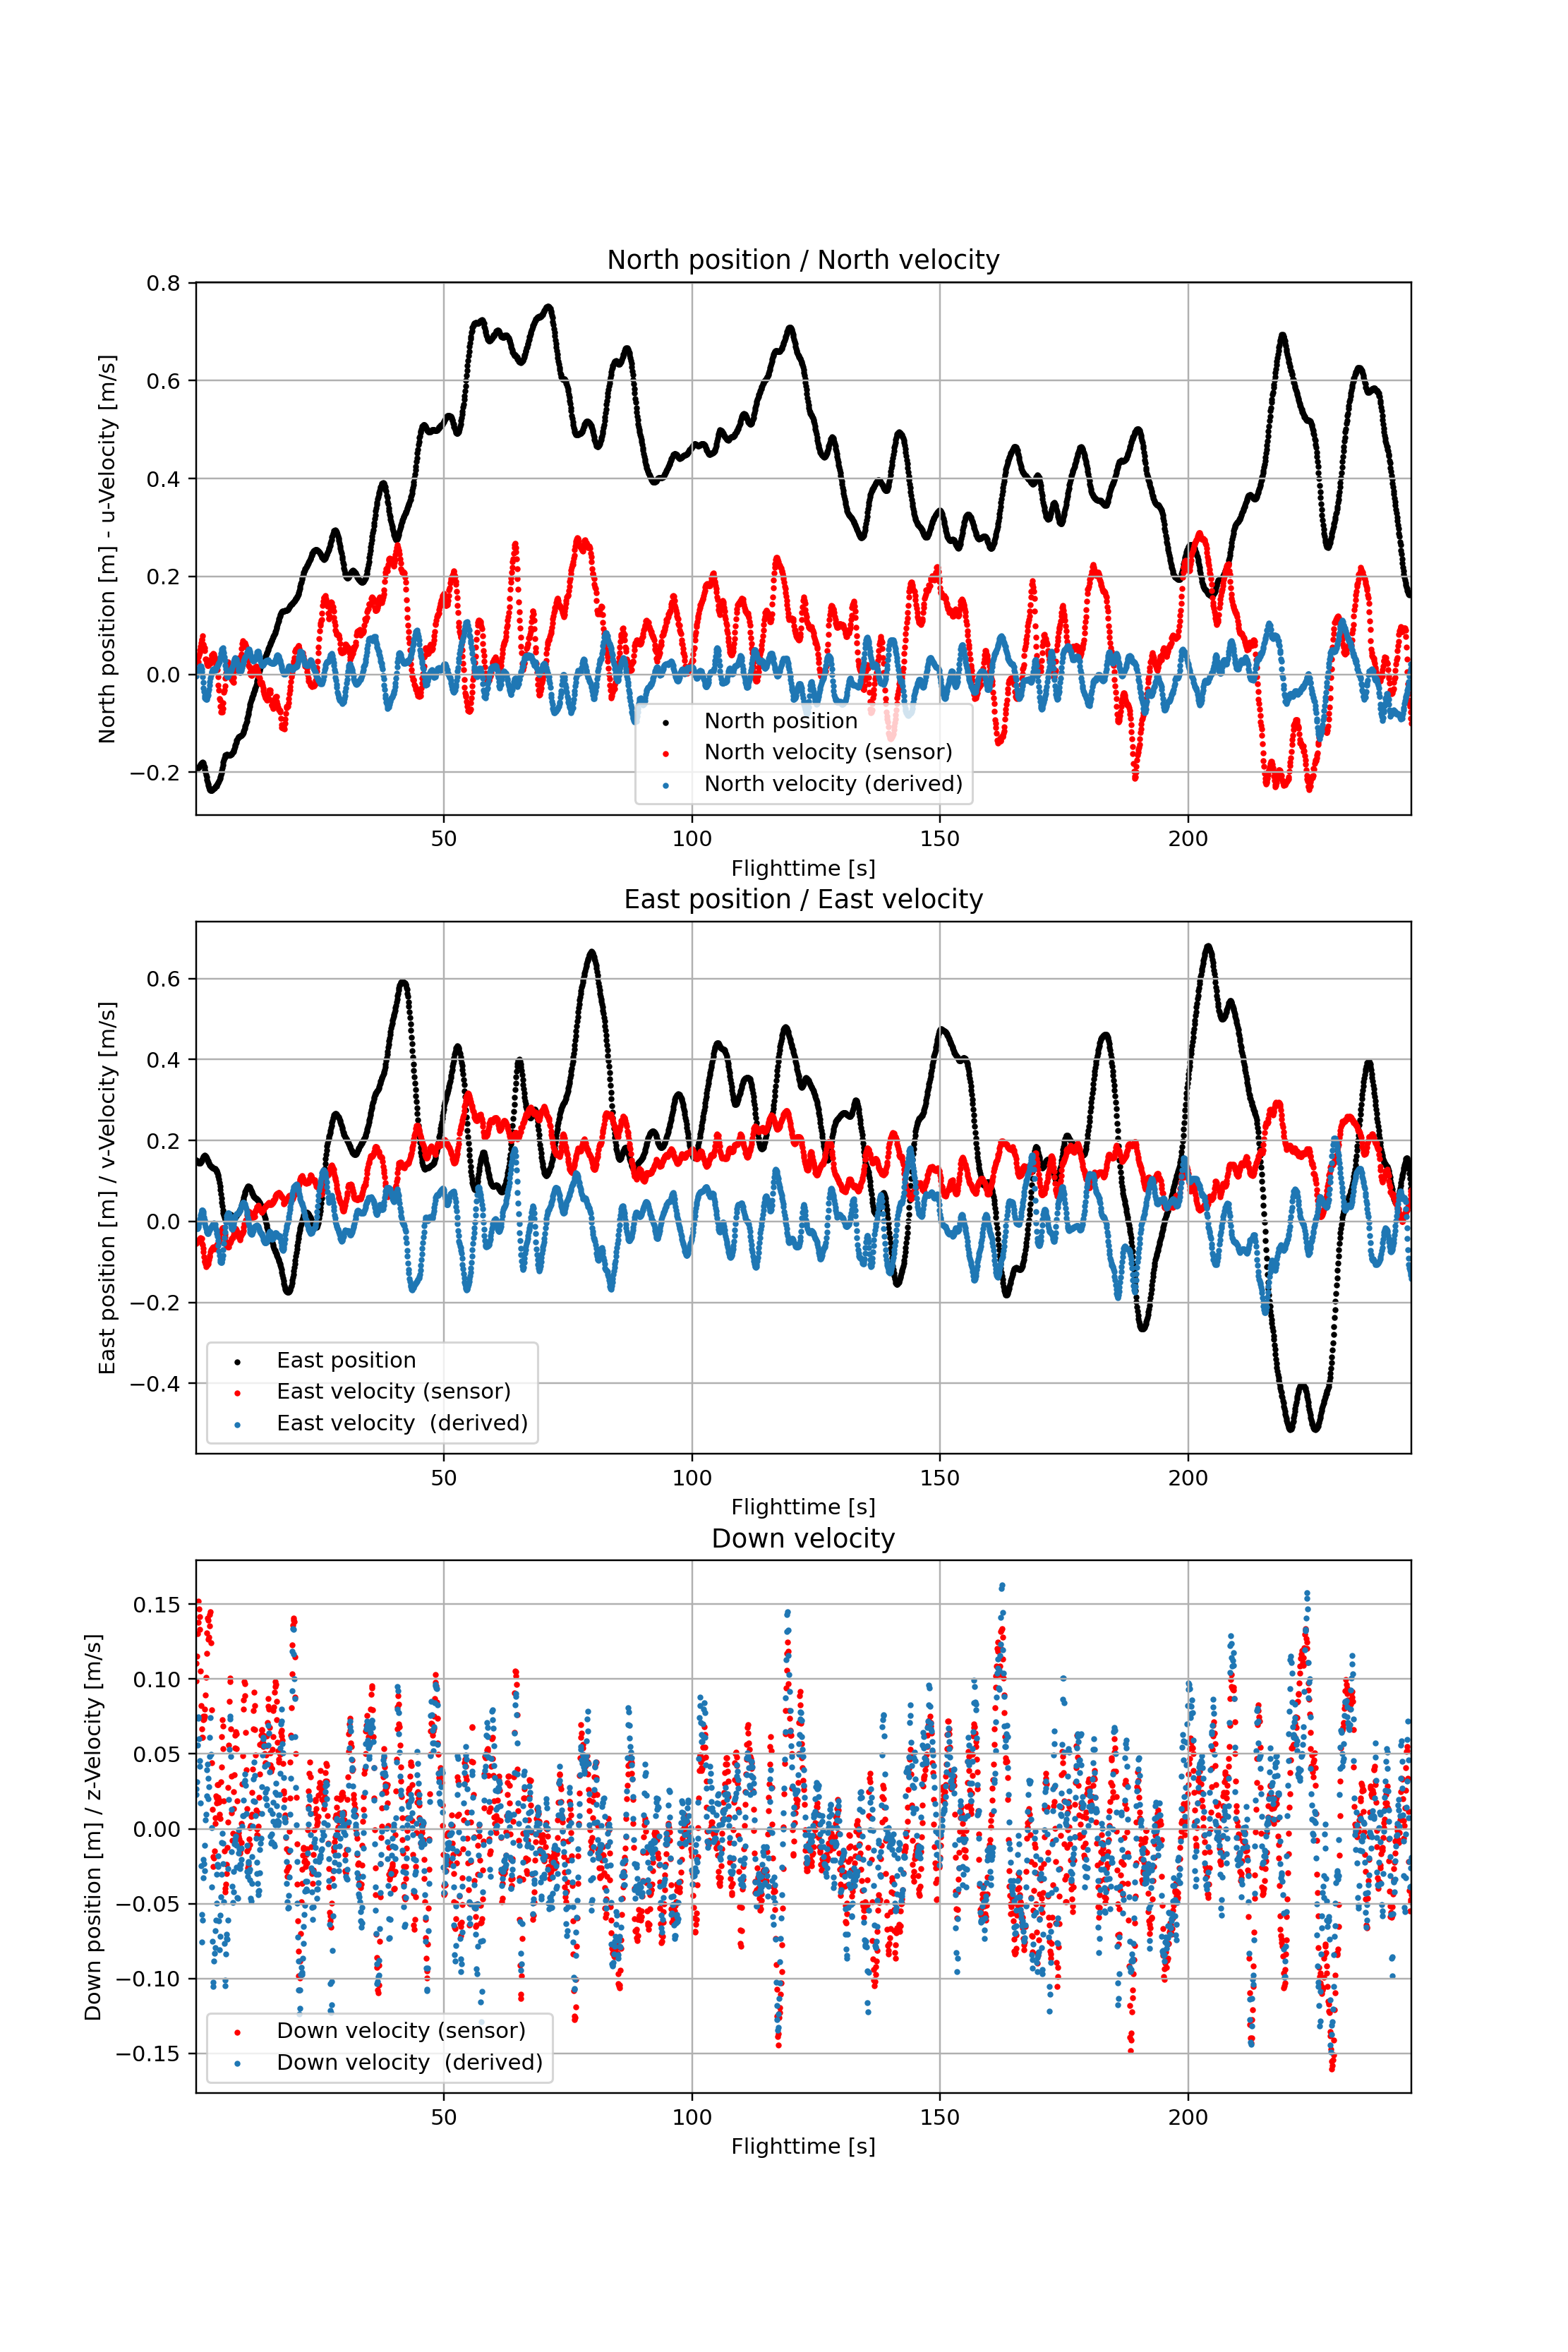

Text(0.5, 1.0, 'Down velocity')

In [89]:
# plot sensor values and calculated values for position and velocity

fig1, ax1 = plt.subplots(3,1, figsize=(10,15))

# plot position from sensor
ax1[0].scatter(time[t0:t1], y[t0:t1], c='k', label='North position', s=markersize)
ax1[1].scatter(time[t0:t1], x[t0:t1], c='k', label='East position', s=markersize)
#ax1[2].scatter(time[t0:t1], z[t0:t1], c='k', label='z (Down)', s=markersize)

# plot velocity from sensor
ax1[0].scatter(time[t0:t1], u[t0:t1], c='r', label='North velocity (sensor)', s=markersize)
ax1[1].scatter(time[t0:t1], v[t0:t1], c='r', label='East velocity (sensor)', s=markersize)
ax1[2].scatter(time[t0:t1], w[t0:t1], c='r', label='Down velocity (sensor)', s=markersize)
#ax1.scatter(time[t0:t1], u[t0:t1]-curve.reshape(-1)[t0:t1], c='r', label='u (sensor)', s=markersize)

# plot derived velocity
ax1[0].scatter(time[t0:t1], dy[t0:t1], c='tab:blue', label='North velocity (derived)', s=markersize)
ax1[1].scatter(time[t0:t1], dx[t0:t1], c='tab:blue', label='East velocity  (derived)', s=markersize)
ax1[2].scatter(time[t0:t1], dz[t0:t1], c='tab:blue', label='Down velocity  (derived)', s=markersize)

# plot integrated position
#ax1.scatter(time[t0:t1], pos_int[t0:t1], c='tab:cyan', label='North (integrated)', s=markersize)

for i in range(3):
    ax1[i].set_xlim(time[0], time[-1])
    ax1[i].grid()
    ax1[i].legend()
    ax1[i].set_xlabel('Flighttime [s]')

ax1[0].set_ylabel('North position [m] - u-Velocity [m/s]')
ax1[1].set_ylabel('East position [m] / v-Velocity [m/s]')
ax1[2].set_ylabel('Down position [m] / z-Velocity [m/s]')

ax1[0].set_title('North position / North velocity')
ax1[1].set_title('East position / East velocity')
ax1[2].set_title('Down velocity')

## Findings
* velocity signal in north and east direction does not match position signal-> both u and v are constantly above 0, the vehicle would drift away, if they were correct

<IPython.core.display.Javascript object>


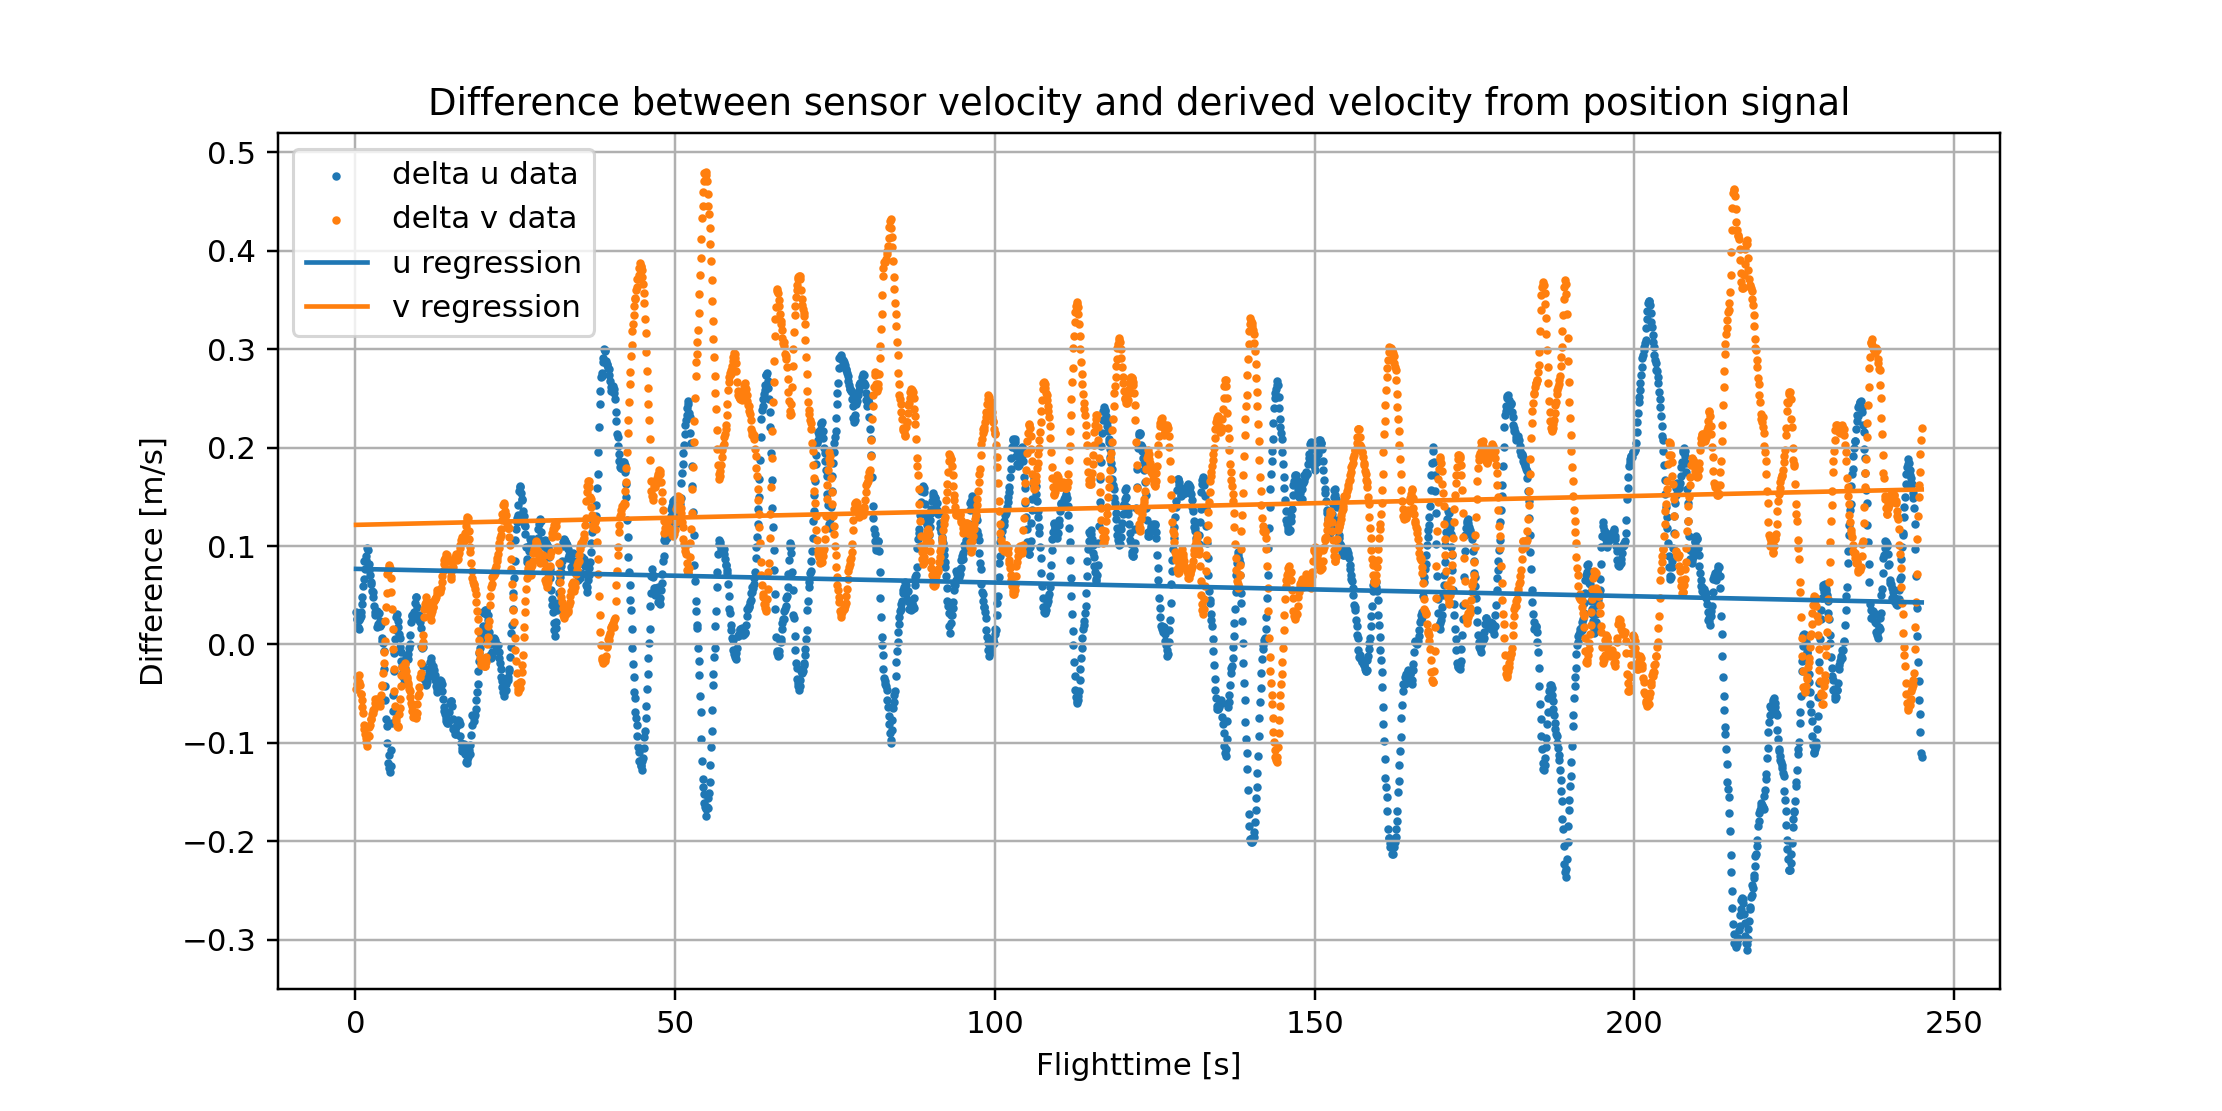

In [90]:
# Plot difference between sensor velocity and derived velocity

u_difference = u - dy
v_difference = v - dx

# Linear regression model for velocit difference
u_reg = linear_model.LinearRegression().fit(time.reshape(-1,1), u_difference.reshape(-1,1))
v_reg = linear_model.LinearRegression().fit(time.reshape(-1,1), v_difference.reshape(-1,1))

u_curve = u_reg.predict(time.reshape(-1,1))
v_curve = v_reg.predict(time.reshape(-1,1))

fig2, ax2 = plt.subplots(figsize=(10,5))
ax2.scatter(time, u_difference, s=markersize, label = 'delta u data')
ax2.scatter(time, v_difference, s=markersize, label = 'delta v data')

ax2.plot(time, u_curve, label = 'u regression')
ax2.plot(time, v_curve, label = 'v regression')

ax2.set_title('Difference between sensor velocity and derived velocity from position signal')
ax2.set_xlabel('Flighttime [s]')
ax2.set_ylabel('Difference [m/s]')
ax2.grid()
ax2.legend()

## Finding a criteria for hovering

As a first step, we need a criteria to identify hover points in the data. Using the norm of the velocit vector is a simple first approach.

$v_{norm} = ||v|| = \sqrt{\textbf{u}² + \textbf{v}² + \textbf{w}²}$

A fraction of the induced velocity functions as a threshold for $v_{norm}$

$v_i = \sqrt{\frac{W}{2 \rho A}}$

With a vehicle weight of 15 kg, standard air density of 1.225 kg/m³, and four pairs of rotors with 12 in radius, the induced velocity is:

In [91]:
W = 15*9.81
rho = 1.225
A = np.pi * (0.3048**2)
v_i = np.sqrt((2*W)/(rho*4*A))
print("Induced velocity: {} m/s".format(v_i))

Induced velocity: 14.345219306215128 m/s


In [92]:
# get vnorm of sensor and derived velocity
v_norm = ulg_df['ulg_pv_df']['vnorm'].values
dv_norm = np.sqrt(dx**2 + dy**2 + dz**2)

In [119]:
# set percentage of induced velocity as a limit
v_limit = 0.15 # 0.5% of induced velocity
dv_limit = 0.07

In [120]:
# filter out values above v_limit
v_filtered = np.where(v_norm < v_limit)[0]
dv_filtered = np.where(dv_norm < dv_limit)[0]

<IPython.core.display.Javascript object>


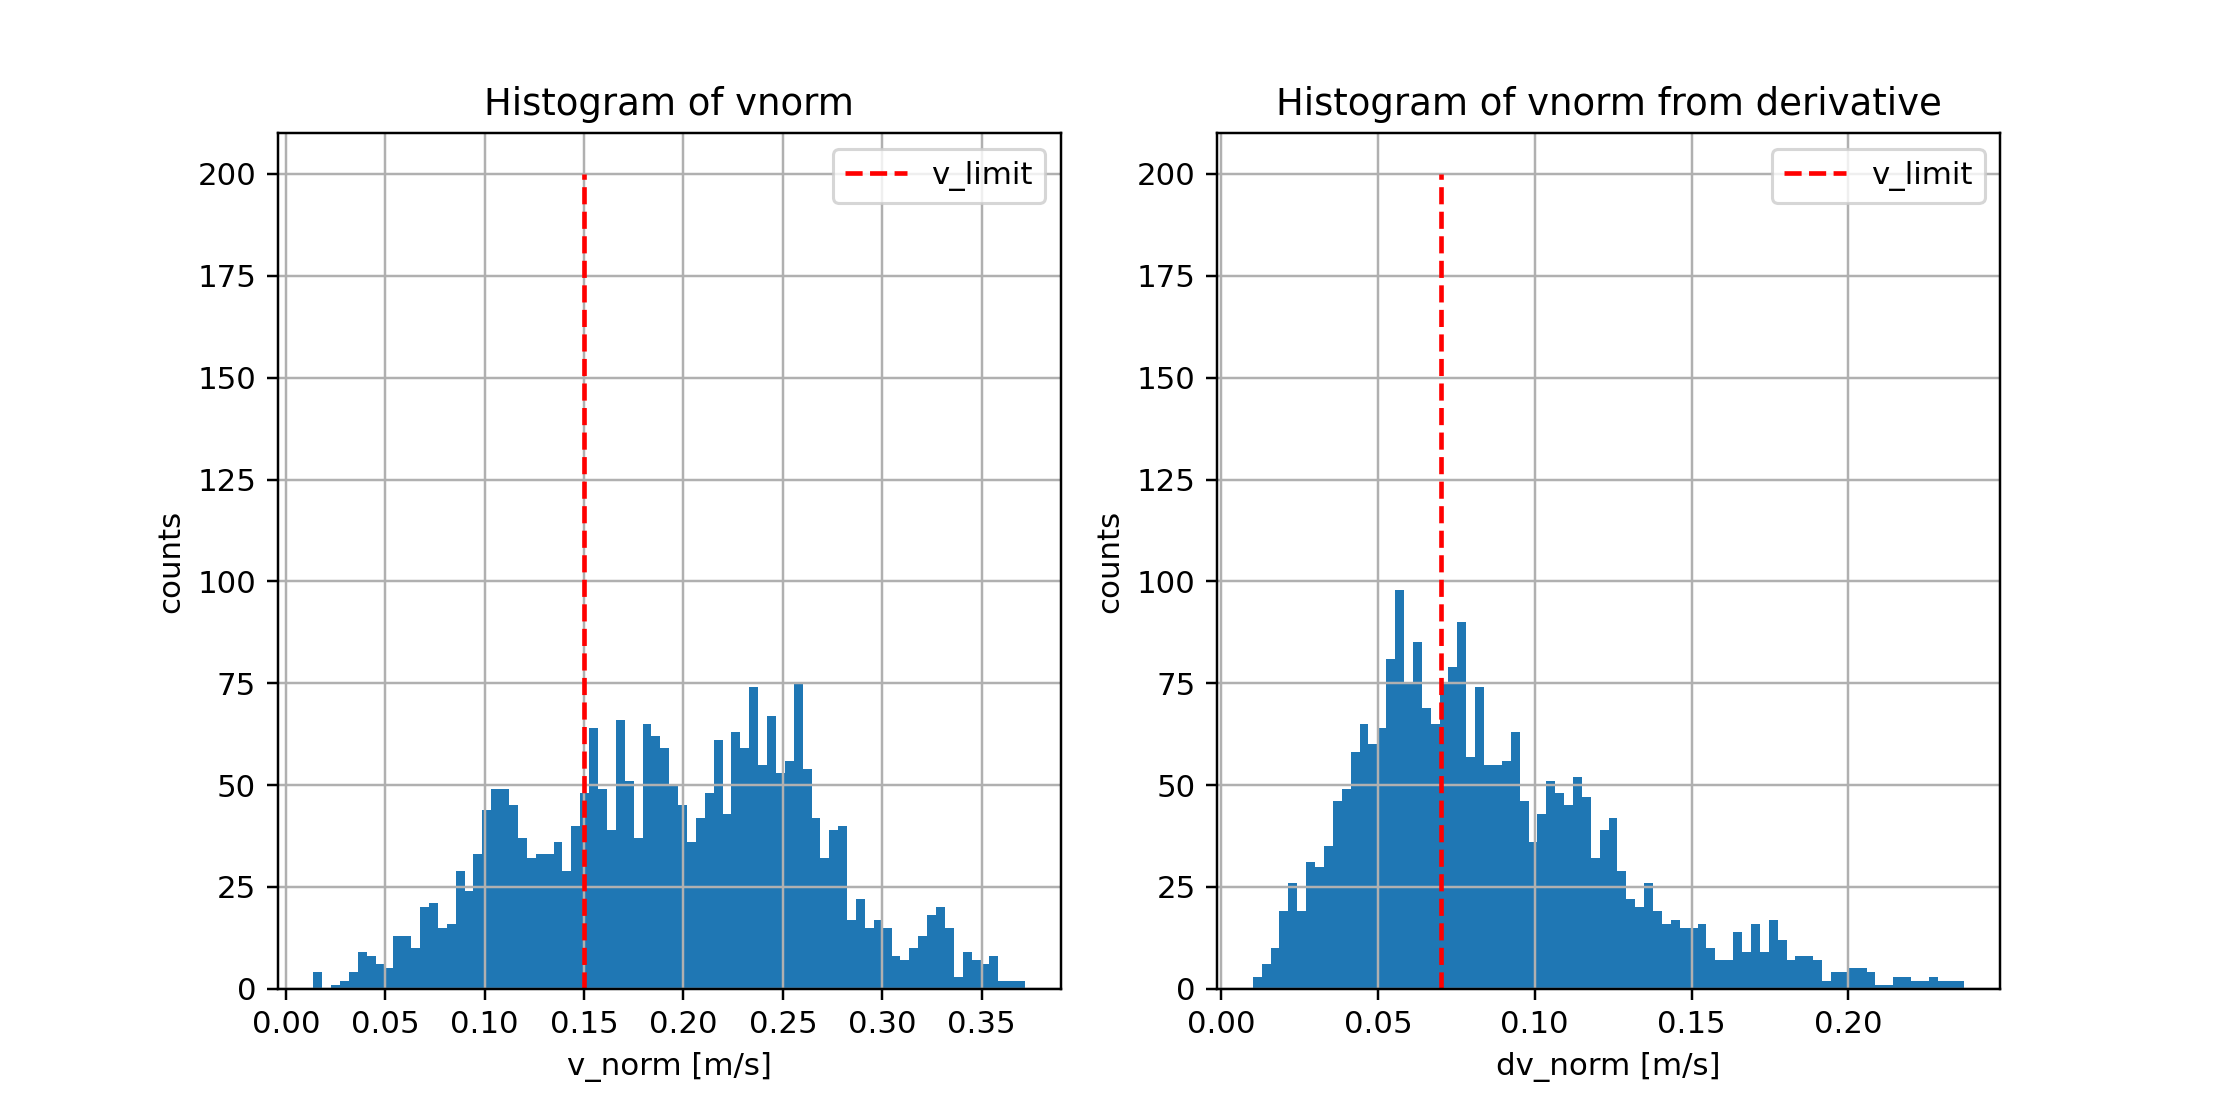

In [121]:
# plot histogram of vnorm with corresponding limit

fig4, ax4 = plt.subplots(1, 2, figsize=(10,5))

ax4[0].hist(v_norm, bins=80)
ax4[0].plot([v_limit, v_limit],[0, 200], 'r--', label='v_limit')
ax4[0].set_xlabel('v_norm [m/s]')
ax4[0].set_ylabel('counts')
ax4[0].set_title('Histogram of vnorm')
ax4[0].grid()
ax4[0].legend()

ax4[1].hist(dv_norm, bins=80)
ax4[1].plot([dv_limit, dv_limit],[0, 200], 'r--', label='v_limit')
ax4[1].set_xlabel('dv_norm [m/s]')
ax4[1].set_ylabel('counts')
ax4[1].set_title('Histogram of vnorm from derivative')
ax4[1].grid()
ax4[1].legend()


<IPython.core.display.Javascript object>


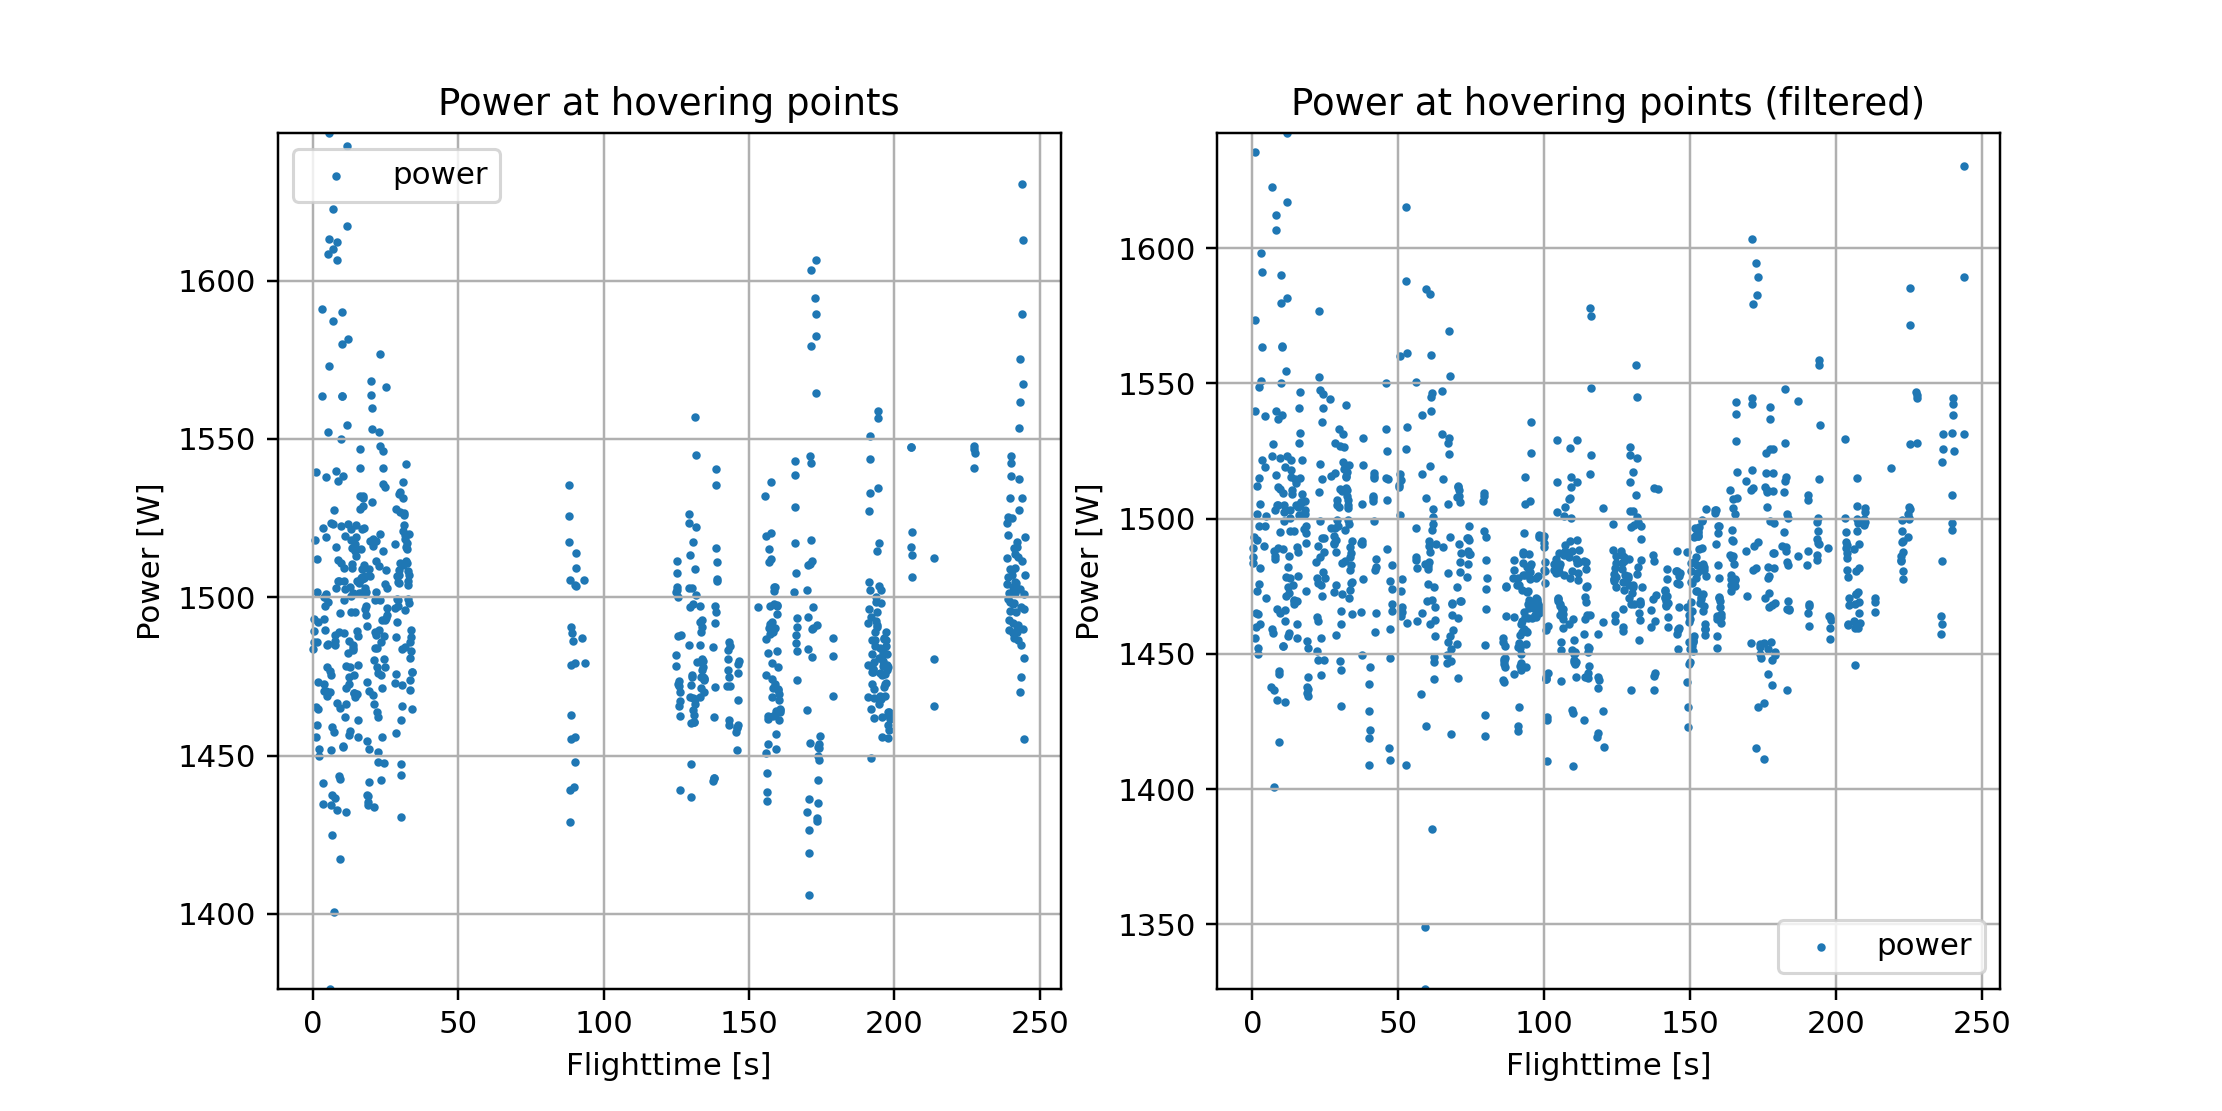

In [122]:
# Plot power data points of filtered values

fig3, ax3 = plt.subplots(1,2, figsize=(10,5))

ax3[0].scatter(time[v_filtered], p_total[v_filtered], s=markersize, label='power')
ax3[0].set_ylim(min(p_total[v_filtered]), max(p_total[v_filtered]))
ax3[0].set_title('Power at hovering points')
ax3[0].set_xlabel('Flighttime [s]')
ax3[0].set_ylabel('Power [W]')
ax3[0].grid()
ax3[0].legend()

ax3[1].scatter(time[dv_filtered], p_total[dv_filtered], s=markersize, label='power')
ax3[1].set_ylim(min(p_total[dv_filtered]), max(p_total[dv_filtered]))
ax3[1].set_xlabel('Flighttime [s]')
ax3[1].set_ylabel('Power [W]')
ax3[1].set_title('Power at hovering points (filtered)')
ax3[1].grid()
ax3[1].legend()

#print("Mean power (raw) = {}".format(np.mean(p_total[v_filtered])))
#print("Std power (raw) = {}".format(np.std(p_total[v_filtered])))

#print("Mean power (filtered) = {}".format(np.mean(p_total[dv_filtered])))
#print("Std power (filtered) = {}".format(np.std(p_total[dv_filtered])))

In [123]:
# Split sequences and discard all sequences below a given length
min_length = 20
sequence_v = split_sequences(v_filtered, min_length)
sequence_dv = split_sequences(dv_filtered, min_length)
print("Found {} sequences with min length of {} data points ({} seconds)"
      .format(len(sequence_v), min_length, min_length / 10))

print("Found {} sequences with min length of {} data points ({} seconds in filtered data)"
      .format(len(sequence_dv), min_length, min_length / 10))

Found 8 sequences with min length of 20 data points (2.0 seconds)
Found 10 sequences with min length of 20 data points (2.0 seconds in filtered data)


In [124]:
# Get length and standard deviation of all sequences
for index, seq in enumerate(sequence_v):
    print("Sequence {} with length {} : sigma={}".format(index, len(seq), np.std(seq)))

Sequence 0 with length 166 : sigma=47.91920283143283
Sequence 1 with length 46 : sigma=13.275918047351754
Sequence 2 with length 61 : sigma=17.60681686165901
Sequence 3 with length 29 : sigma=8.366600265340756
Sequence 4 with length 53 : sigma=15.297058540778355
Sequence 5 with length 22 : sigma=6.34428877022476
Sequence 6 with length 76 : sigma=21.937410968480304
Sequence 7 with length 64 : sigma=18.472953201911167


In [125]:
# select sequence
index_v = sequence_v[0]
index_dv = sequence_dv[0]

<IPython.core.display.Javascript object>


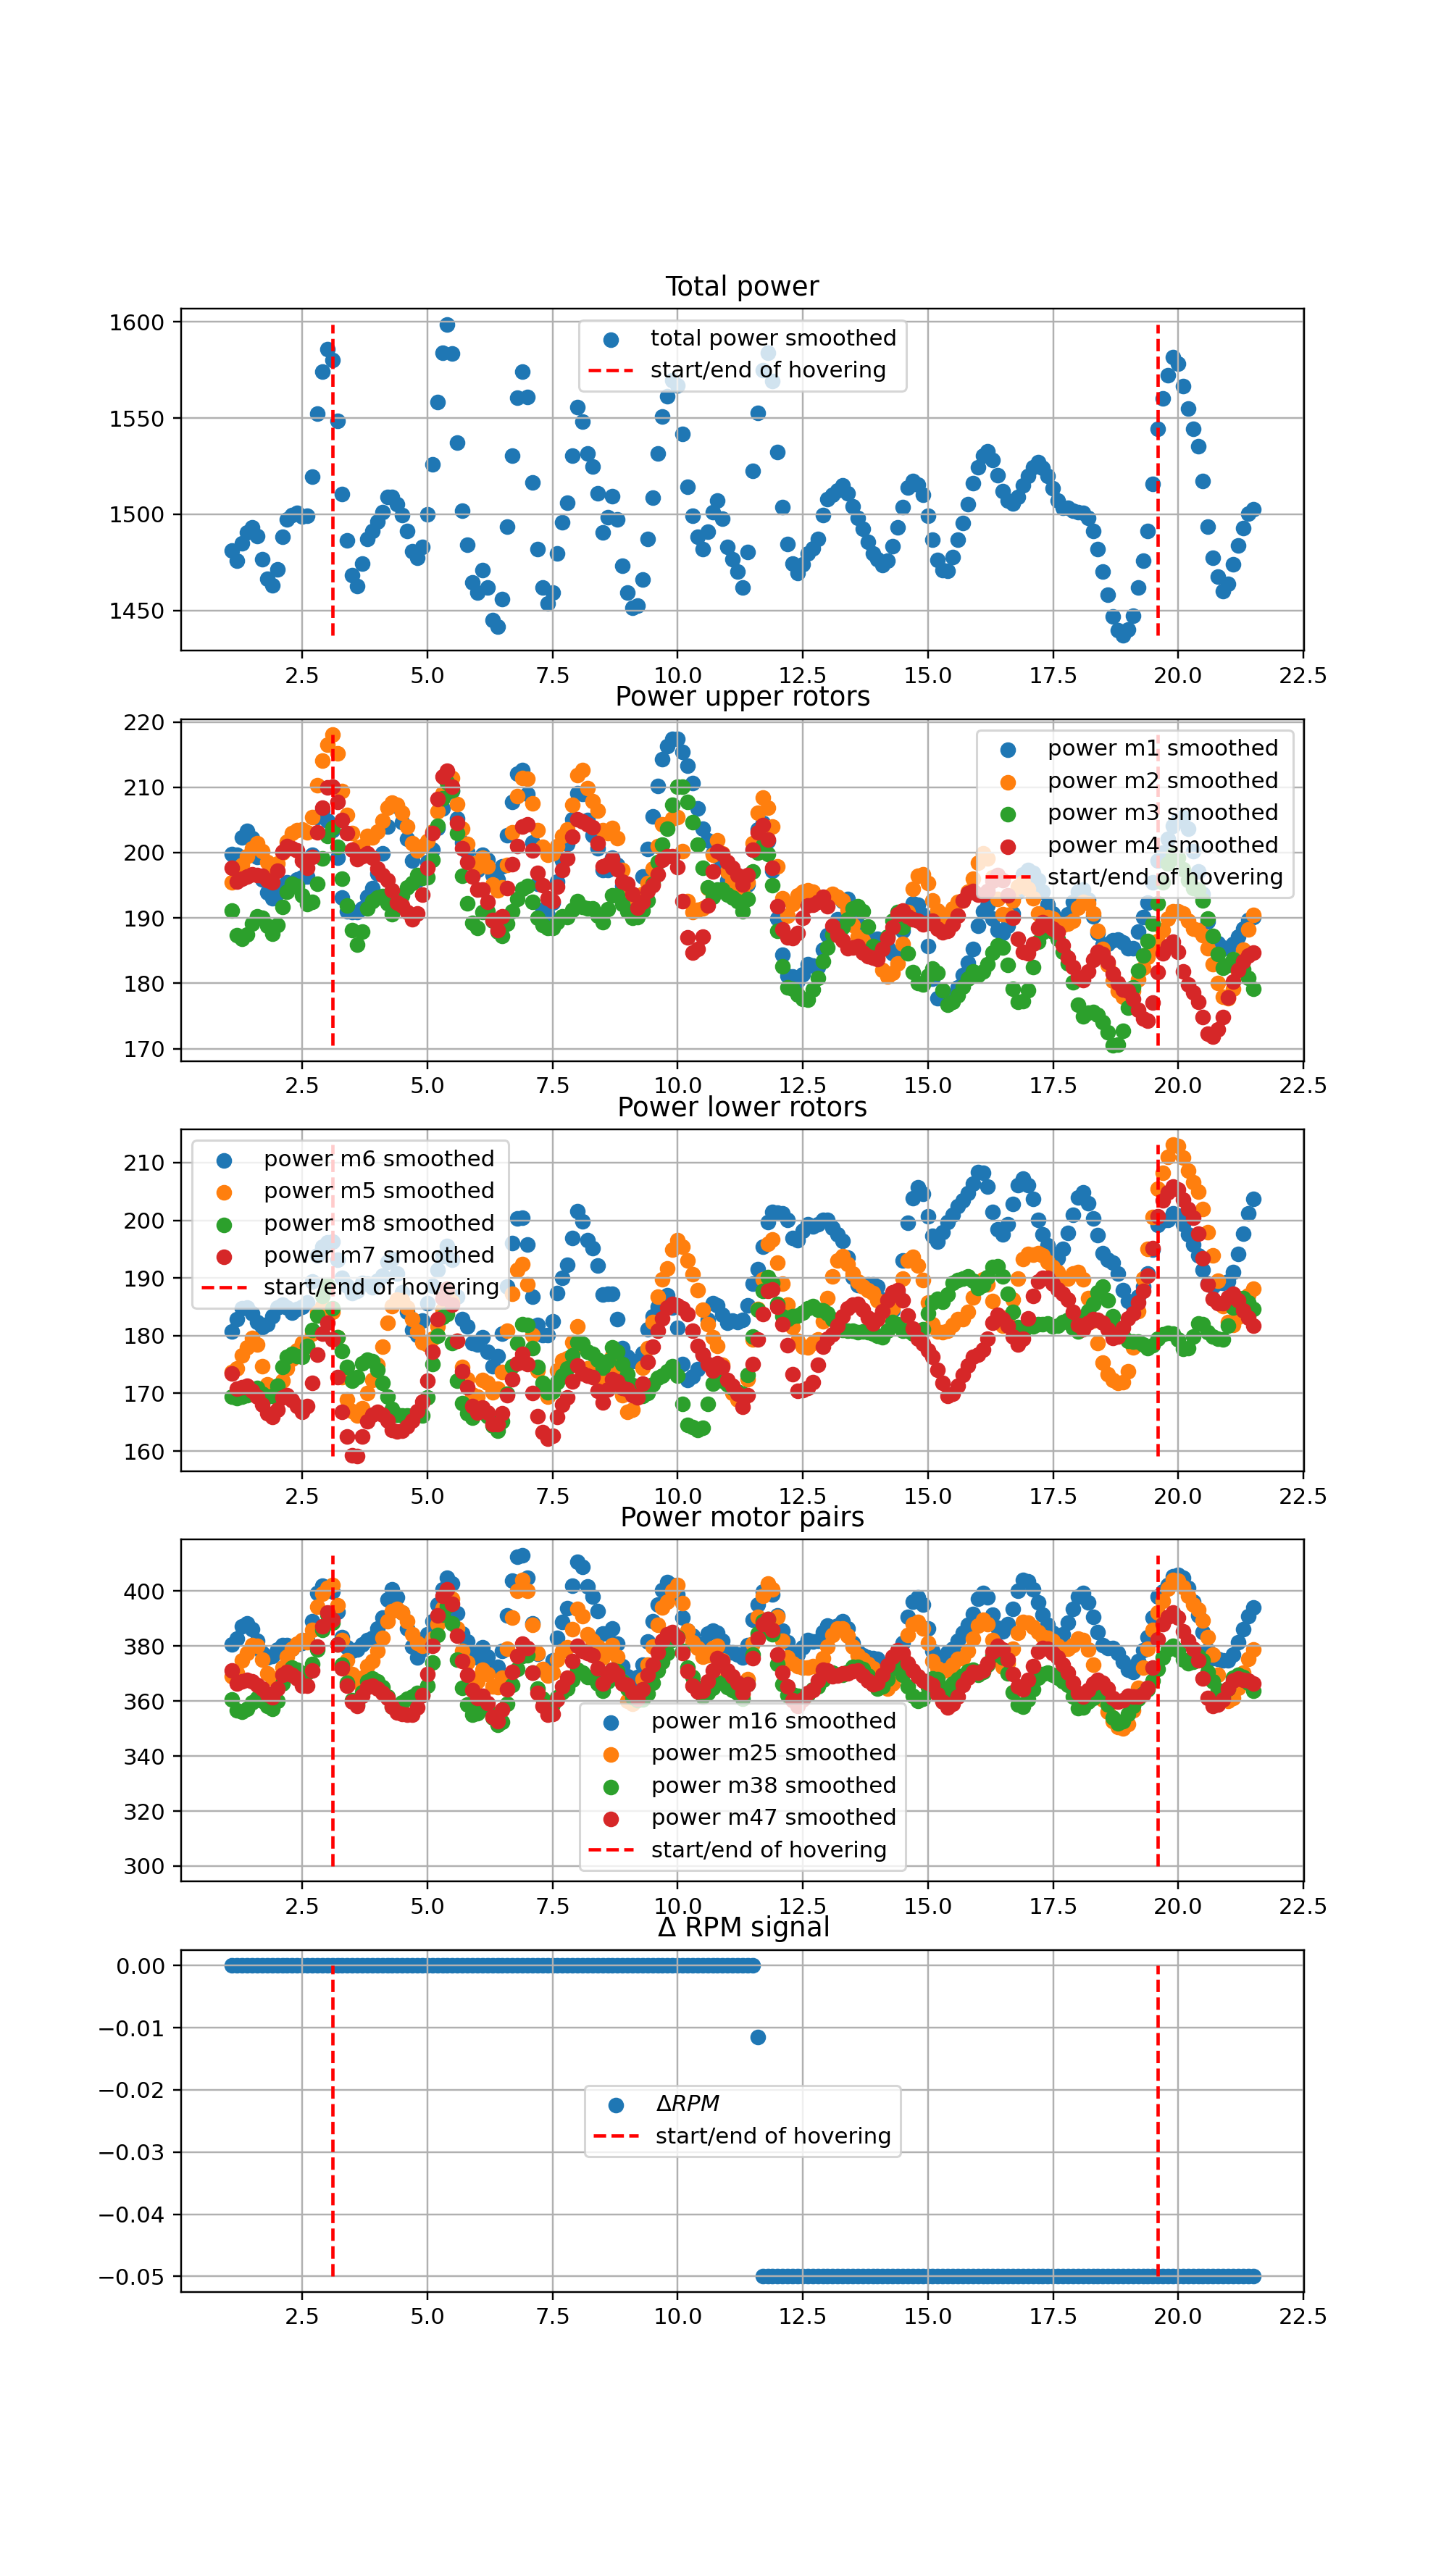

In [126]:
# Plot power and delta RPM command

fig5, ax5 = plt.subplots(5,1, figsize=(9,16))

# set how many data points before and after hovering should be displayed
t_pre = 20
t_post = 20

index = index_v
t0 = index[0] - t_pre
t1 = index[-1] + t_post

# set boundaries to show hovering period
left_boundary_x = [time[index[0]], time[index[0]]]
right_boundary_x = [time[index[-1]], time[index[-1]]]

#y_boundary = y_bound(p_total_av, t0, t1)


ax5[0].set_title('Total power')
ax5[0].scatter(time[t0:t1], p_total_av[t0:t1], label='total power smoothed')
#ax5[0].scatter(time[t0:t1], p_lower_total_av[t0:t1], label='total upper smoothed')
ax5[0].plot(left_boundary_x, get_y_bound(p_total_av, t0, t1), 'r--', label='start/end of hovering')
ax5[0].plot(right_boundary_x, get_y_bound(p_total_av, t0, t1), 'r--')

ax5[1].set_title('Power upper rotors')
ax5[1].scatter(time[t0:t1], p_motor_av['11'][t0:t1], label='power m1 smoothed')
ax5[1].scatter(time[t0:t1], p_motor_av['12'][t0:t1], label='power m2 smoothed')
ax5[1].scatter(time[t0:t1], p_motor_av['13'][t0:t1], label='power m3 smoothed')
ax5[1].scatter(time[t0:t1], p_motor_av['14'][t0:t1], label='power m4 smoothed')
ax5[1].plot(left_boundary_x, get_y_bound(p_upper_av, t0, t1), 'r--', label='start/end of hovering')
ax5[1].plot(right_boundary_x, get_y_bound(p_upper_av, t0, t1), 'r--')

ax5[2].set_title('Power lower rotors')
ax5[2].scatter(time[t0:t1], p_motor_av['16'][t0:t1], label='power m6 smoothed')
ax5[2].scatter(time[t0:t1], p_motor_av['15'][t0:t1], label='power m5 smoothed')
ax5[2].scatter(time[t0:t1], p_motor_av['18'][t0:t1], label='power m8 smoothed')
ax5[2].scatter(time[t0:t1], p_motor_av['17'][t0:t1], label='power m7 smoothed')
ax5[2].plot(left_boundary_x, get_y_bound(p_lower_av, t0, t1), 'r--', label='start/end of hovering')
ax5[2].plot(right_boundary_x, get_y_bound(p_lower_av, t0, t1), 'r--')

ax5[3].set_title('Power motor pairs')
ax5[3].scatter(time[t0:t1], p_motorpair_av['16'][t0:t1], label='power m16 smoothed')
ax5[3].scatter(time[t0:t1], p_motorpair_av['25'][t0:t1], label='power m25 smoothed')
ax5[3].scatter(time[t0:t1], p_motorpair_av['38'][t0:t1], label='power m38 smoothed')
ax5[3].scatter(time[t0:t1], p_motorpair_av['47'][t0:t1], label='power m47 smoothed')
ax5[3].plot(left_boundary_x, get_y_bound(p_motorpair_av, t0, t1), 'r--', label='start/end of hovering')
ax5[3].plot(right_boundary_x, get_y_bound(p_motorpair_av, t0, t1), 'r--')

ax5[4].set_title('$\Delta$ RPM signal')
ax5[4].scatter(time[t0:t1], nsh_cmd[t0:t1], label='$\Delta RPM$')
ax5[4].plot(left_boundary_x, get_y_bound(nsh_cmd, t0, t1), 'r--', label='start/end of hovering')
ax5[4].plot(right_boundary_x, get_y_bound(nsh_cmd, t0, t1), 'r--')


for i in range(5):
    
    ax5[i].grid()
    ax5[i].legend()

In [127]:
# map average power of hovering sequence to delta PRM 
avg_rpm_v = []
avg_pow_v = []

avg_rpm_dv = []
avg_pow_dv = []

for sequence in sequence_v:
    avg_rpm_v.append(np.average(nsh_cmd[sequence]))
    avg_pow_v.append(np.average(p_total[sequence]))
    
for sequence in sequence_dv:
    avg_rpm_dv.append(np.average(nsh_cmd[sequence]))
    avg_pow_dv.append(np.average(p_total[sequence]))

<IPython.core.display.Javascript object>


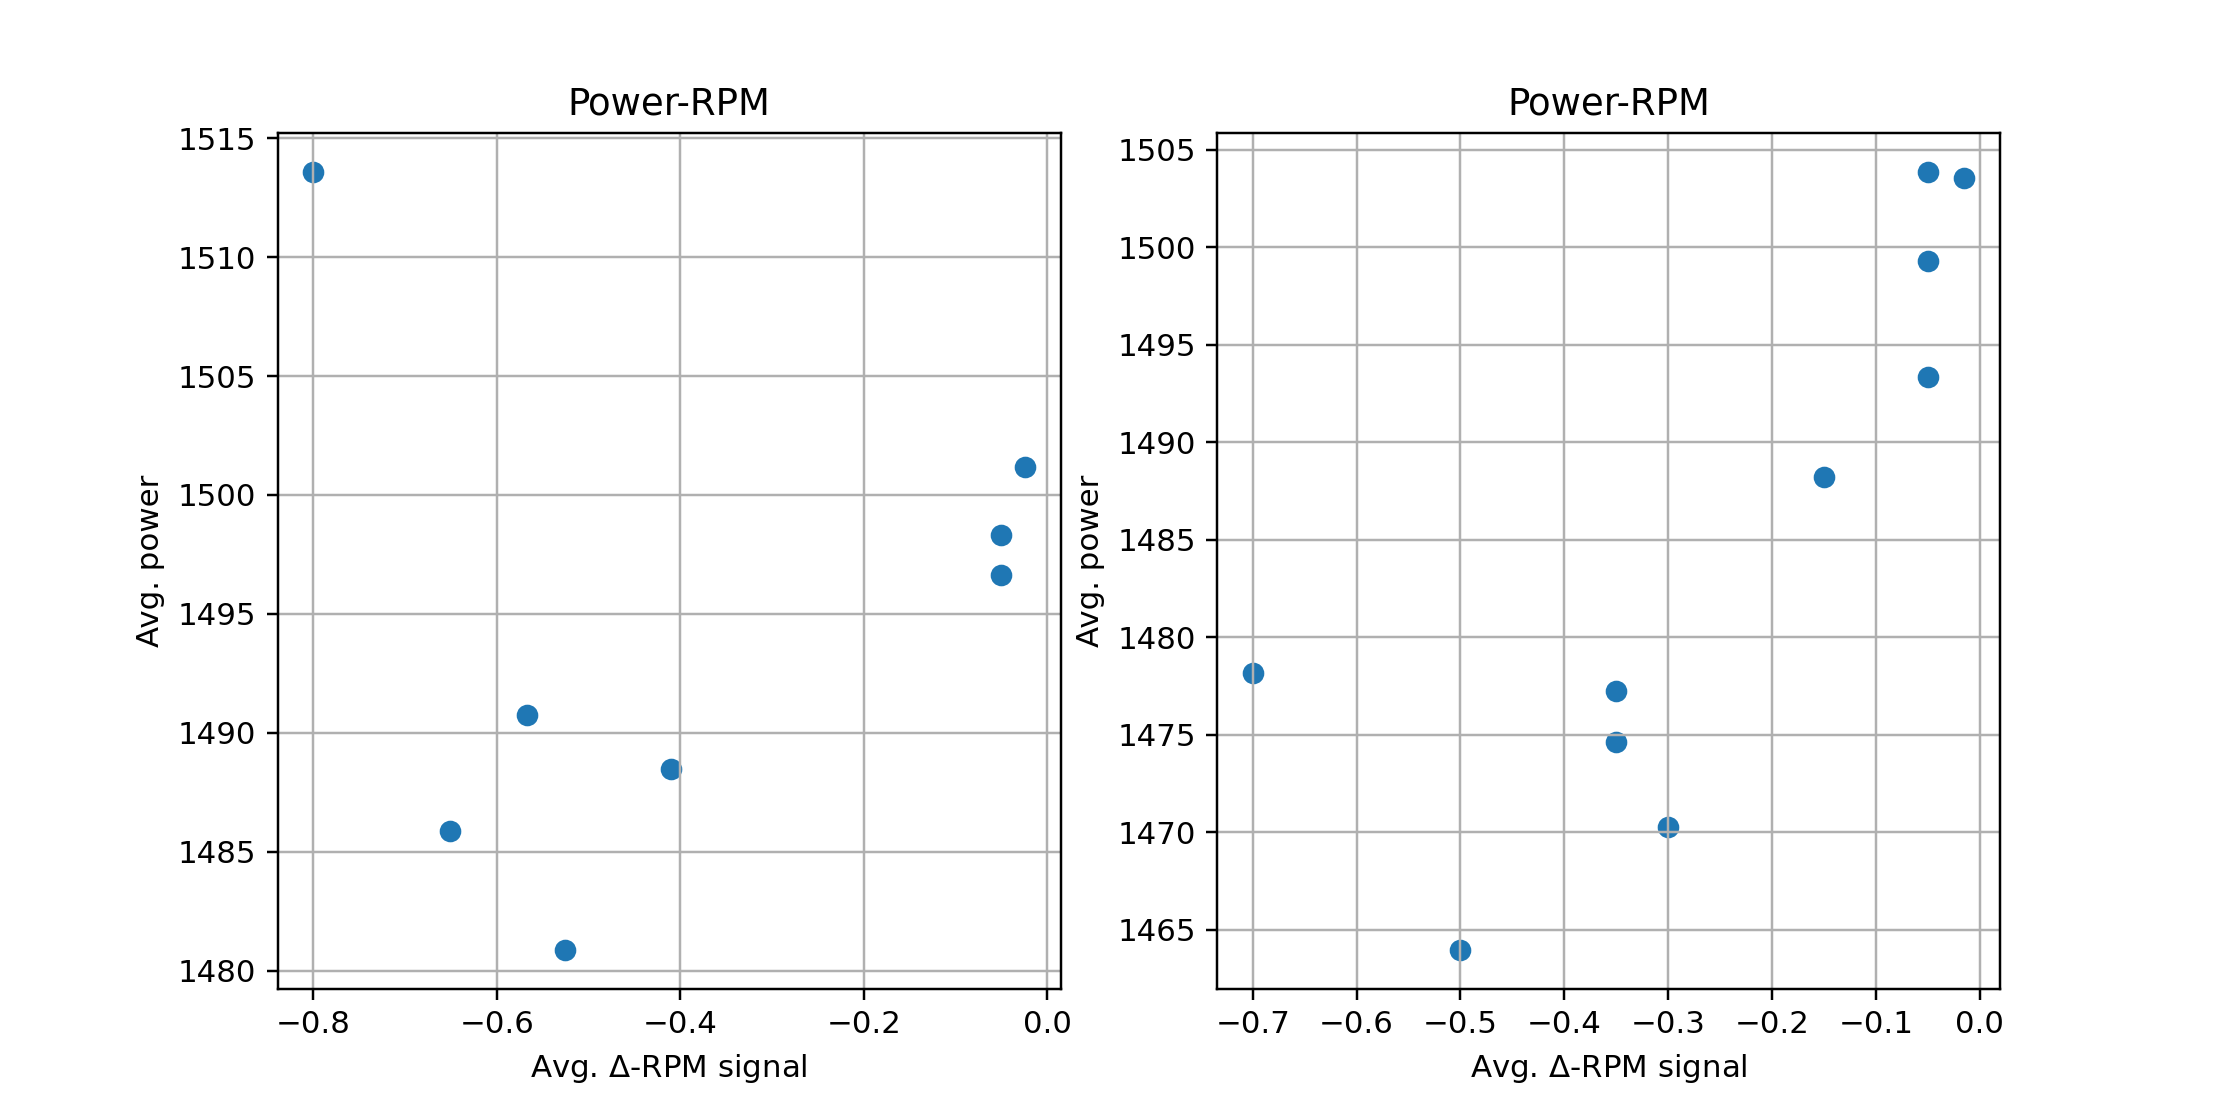

Text(0, 0.5, 'Avg. power')

In [128]:
fig6, ax6 = plt.subplots(1,2, figsize=(10,5))

ax6[0].scatter(avg_rpm_v, avg_pow_v)
ax6[0].grid()
ax6[0].set_title('Power-RPM')
ax6[0].set_xlabel('Avg. $\Delta$-RPM signal')
ax6[0].set_ylabel('Avg. power')

ax6[1].scatter(avg_rpm_dv, avg_pow_dv)
ax6[1].grid()
ax6[1].set_title('Power-RPM')
ax6[1].set_xlabel('Avg. $\Delta$-RPM signal')
ax6[1].set_ylabel('Avg. power')